# ディープ畳み込みGAN(Deep Convolutional GAN:DCGAN)

### 転置畳み込み
通常、畳み込み演算は特徴空間のダウンサンプリングに使われるが、特徴空間のアップサンプリングには転置畳み込み演算が使われる。  
入力特徴マップの要素の間に0を挿入するという仕組みになっている。

### バッチ正規化
層の入力を正規化し、訓練中にそれらの分布を変化させないことで、より高速で効果的な収束を可能にするというもの。  
畳み込み層の後に４次元テンソル$Z$で取得した事前活性化特徴マップがある。このテンソルの形状は$[m \times h \times w \times c]$であり、$m$はバッチサイズ、$h \times w$は特徴マップの空間次元、$c$はチャネルの個数を表す。
1. ミニバッチごとに総入力の平均と標準偏差を求める。（それぞれサイズは$c$）
   1. $$\mathbf{\mu}_B = \frac{1}{m \times h \times w} \sum_{i,j,k} \mathbf{Z}^{i,j,k}$$
   2. $$\mathbf{\sigma}^2_B = \frac{1}{m \times h \times w} \sum_{i,j,k} (\mathbf{Z}^{i,j,k} - \mathbf{\mu}_B)^2$$
2. バッチ内の全データの総入力を標準化する。$\epsilon$は微小数字。
   1. $$\mathbf{Z}^i_{std} = \frac{\mathbf{Z}^i-\mathbf{\mu}_B}{\mathbf{\sigma}+\epsilon}$$
3. 2つの学習パラメータ$\mathbf{\gamma}$と$\mathbf{\beta}$を使って、正規化された総入力のスケーリングとシフトを行う。（それぞれサイズは$c$）
   1. $$\mathbf{A}^i_{pre}=\mathbf{\gamma} \mathbf{Z}^i_{std} + \mathbf{\beta}$$
   2. 正規化された特徴量のシフトと散布度をバッチ正規化で制御できるようになる。

PyTorch APIにはnn.BatchNorm2dクラスがある。１次元の場合は、nn.BatchNorm1d。バイアスユニットは$\mathbf{\beta}$があるため冗長だから通常使われない。

### ネットワーク
#### 生成器
転置畳み込み&バッチ正規化&LeakyRelu  
z-(100)->(128, 4, 4)->(64, 7, 7)->(32, 14, 14)->(1, 28, 28)-偽の生成された画像
#### 識別器
畳み込み&バッチ正規化&LeakyRelu  
入力画像-(1, 28, 28)->(32, 14, 14)->(64, 7, 7)->(128, 4, 4)->(1, 1, 1)-(SIgmoid)->(1)


In [1]:
import torch
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


In [2]:
import torchvision
from torchvision import datasets, transforms

path='../第12章_ニューラルネットワークの訓練をPyTorchで並列化する'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])
mnist_dataset = torchvision.datasets.MNIST(
    root=path,
    train=True,
    download=False,
    transform=transform
)
example, label = next(iter(mnist_dataset))
print(f'Min: {example.min()}, Max: {example.max()}')
print(example.shape)

Min: -1.0, Max: 1.0
torch.Size([1, 28, 28])


In [3]:
import numpy as np
from torch.utils.data import DataLoader
batch_size = 64
torch.manual_seed(1)
np.random.seed(1)
mnist_dl = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [4]:
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

def make_generator_network(input_size, n_filters):
    model = nn.Sequential(
        nn.ConvTranspose2d(input_size, n_filters*4, 4, 1, 0, bias=False),
        nn.BatchNorm2d(n_filters*4),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(n_filters*4, n_filters*2, 3, 2, 1, bias=False),
        nn.BatchNorm2d(n_filters*2),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(n_filters*2, n_filters, 4, 2, 1, bias=False),
        nn.BatchNorm2d(n_filters),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(n_filters, 1, 4, 2, 1, bias=False),
        nn.Tanh()
    )
    return model

class Discriminator(nn.Module):
    def __init__(self, n_filters):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, n_filters, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            nn.Conv2d(n_filters, n_filters*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_filters*2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(n_filters*2, n_filters*4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(n_filters*4),
            nn.LeakyReLU(0.2),
            nn.Conv2d(n_filters*4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.model(input)
        return output.view(-1, 1).squeeze(0)

In [5]:
z_size = 100
image_size = (28, 28)
n_filters = 32
gen_model = make_generator_network(z_size, n_filters).to(device)
print(gen_model)

Sequential(
  (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2)
  (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2)
  (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2)
  (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): Tanh()
)


In [6]:
disc_model = Discriminator(n_filters).to(device)
print(disc_model)

Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


In [7]:
loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(gen_model.parameters(), 0.0003)
d_optimizer = torch.optim.Adam(disc_model.parameters(), 0.0003)

In [8]:
def create_noise(batch_size, z_size, mode_z):
    if mode_z == 'uniform':
        input_z = torch.rand(batch_size, z_size, 1, 1)*2 - 1
    elif mode_z == 'normal':
        input_z = torch.randn(batch_size, z_size, 1, 1)
    return input_z

In [9]:
# 識別器を訓練する関数
def d_train(x):
    disc_model.zero_grad()
    # 本物の画像からなるバッチを使って識別器を訓練
    batch_size = x.size(0)
    x = x.to(device)
    d_labels_real = torch.ones(batch_size, 1, device=device)
    d_proba_real = disc_model(x)
    d_loss_real = loss_fn(d_proba_real, d_labels_real)
    # 偽物の画像からなるバッチを使って識別器を訓練
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)
    d_proba_fake = disc_model(g_output)
    d_labels_fake = torch.zeros(batch_size, 1, device=device)
    d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)
    # 勾配を逆伝播し、識別器のパラメータだけを最適化
    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    d_optimizer.step()
    return d_loss.item(), d_proba_real.detach(), d_proba_fake.detach()

# 生成器を訓練する関数
def g_train(x):
    gen_model.zero_grad()
    batch_size = x.size(0)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_labels_real = torch.ones(batch_size, 1, device=device)
    g_output = gen_model(input_z)
    d_proba_fake = disc_model(g_output)
    g_loss = loss_fn(d_proba_fake, g_labels_real)
    # 勾配を逆伝播し、生成器のパラメータだけを最適化
    g_loss.backward()
    g_optimizer.step()
    return g_loss.item()

In [10]:
mode_z = 'uniform'
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)

def create_samples(g_model, input_z):
    g_output = g_model(input_z)
    images = torch.reshape(g_output, (batch_size, *image_size))    
    return (images+1)/2.0

epoch_samples = []

num_epochs = 100
torch.manual_seed(1)

for epoch in range(1, num_epochs+1):    
    gen_model.train()
    d_losses, g_losses = [], []
    for i, (x, _) in enumerate(mnist_dl):
        d_loss, d_proba_real, d_proba_fake = d_train(x)
        d_losses.append(d_loss)
        g_losses.append(g_train(x))
 
    print(f'Epoch {epoch:03d} | Avg Losses >>'
          f' G/D {torch.FloatTensor(g_losses).mean():.4f}'
          f'/{torch.FloatTensor(d_losses).mean():.4f}')
    gen_model.eval()
    epoch_samples.append(
        create_samples(gen_model, fixed_z).detach().cpu().numpy())

Epoch 001 | Avg Losses >> G/D 5.8593/0.0667
Epoch 002 | Avg Losses >> G/D 5.4716/0.1117
Epoch 003 | Avg Losses >> G/D 4.3218/0.2230
Epoch 004 | Avg Losses >> G/D 3.6752/0.2814
Epoch 005 | Avg Losses >> G/D 3.4792/0.2668
Epoch 006 | Avg Losses >> G/D 3.3342/0.2329
Epoch 007 | Avg Losses >> G/D 3.2395/0.2673
Epoch 008 | Avg Losses >> G/D 3.3324/0.2357
Epoch 009 | Avg Losses >> G/D 3.5020/0.2242
Epoch 010 | Avg Losses >> G/D 3.5324/0.2472
Epoch 011 | Avg Losses >> G/D 3.6795/0.1931
Epoch 012 | Avg Losses >> G/D 3.7203/0.1852
Epoch 013 | Avg Losses >> G/D 3.7657/0.2048
Epoch 014 | Avg Losses >> G/D 3.8629/0.1769
Epoch 015 | Avg Losses >> G/D 3.8337/0.1899
Epoch 016 | Avg Losses >> G/D 3.9238/0.1677
Epoch 017 | Avg Losses >> G/D 4.0382/0.1891
Epoch 018 | Avg Losses >> G/D 4.0244/0.1667
Epoch 019 | Avg Losses >> G/D 4.1746/0.1552
Epoch 020 | Avg Losses >> G/D 4.0307/0.1881
Epoch 021 | Avg Losses >> G/D 4.0934/0.1648
Epoch 022 | Avg Losses >> G/D 4.1970/0.1507
Epoch 023 | Avg Losses >> G/D 4.

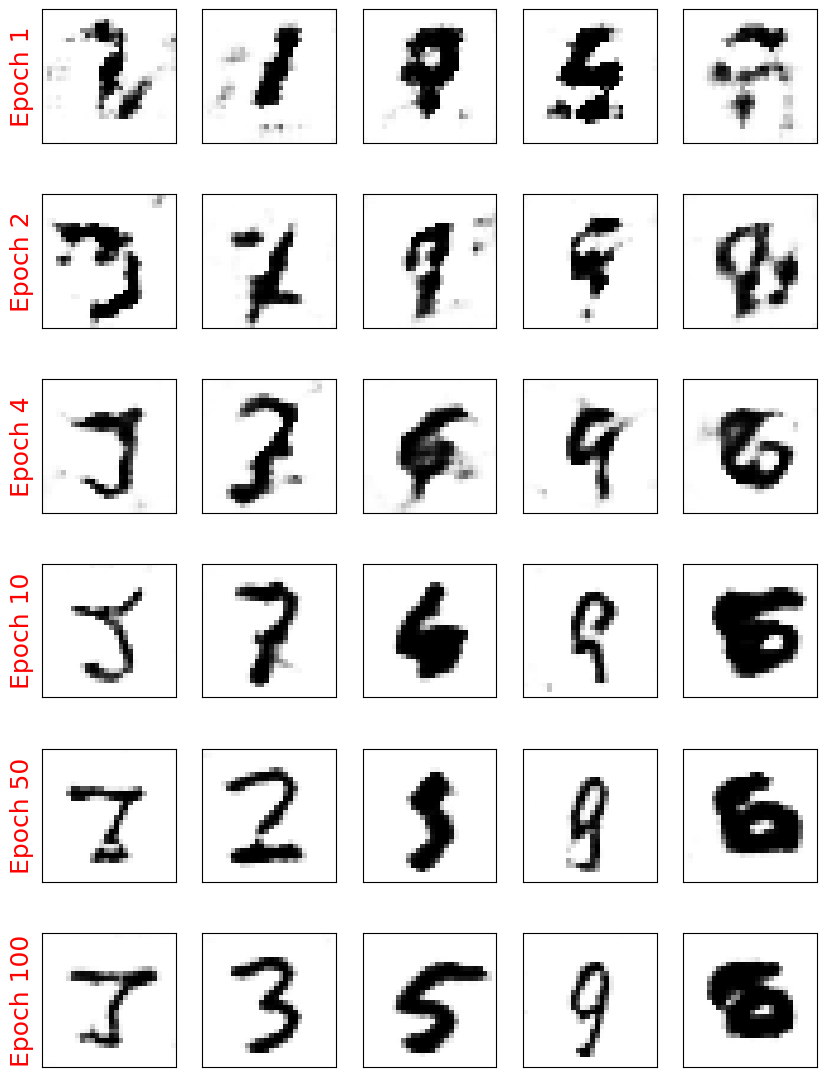

In [13]:
selected_epochs = [1, 2, 4, 10, 50, 100]
# selected_epochs = [1, 10, 20, 30, 50, 70]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, f'Epoch {e}',
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center', 
                transform=ax.transAxes)
        
        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')
    
# plt.savefig('figures/ch17-wgan-gp-samples.pdf')
plt.show()

In [ ]:
dcgan_gen_path = 'dcgan_gen_model.pt'
torch.save(gen_model, dcgan_gen_path)
dcgan_disc_path = 'dcgan_disc_model.pt'
torch.save(disc_model, dcgan_disc_path)

BCELossが画像間のJS情報量を最小化することと同義だが、EM距離を使うことが提案されている。WGAN

**Binary Cross Entropy（BCE）損失は、GANの理論的背景において Jensen-Shannon (JS) 距離と密接な関係があります。**
そのつながりは、GANのオリジナル論文「Generative Adversarial Nets（Goodfellow et al., 2014）」で定式化された**最適な識別器の損失関数が、JS距離を最小化することに一致する**という点にあります。

---

## 🔁 ステップで理解する

### Step 1. GANの目的（2つの分布の一致）

* GANでは、生成器 $G$ が生み出す生成分布 $P_g$ を、訓練データの分布 $P_r$ に近づけることが目的。
* 識別器 $D$ は、入力が本物（$P_r$）か偽物（$P_g$）かを判別しようとする。

---

### Step 2. BCE損失の形式

識別器 $D$ の損失は次のように与えられます：

$$
\mathcal{L}_D = - \mathbb{E}_{x \sim P_r}[\log D(x)] - \mathbb{E}_{x \sim P_g}[\log(1 - D(x))]
$$

これは、**バイナリ分類におけるBinary Cross Entropy（BCE）損失**そのものです。

---

### Step 3. 識別器が最適なときの出力

理論的に、識別器が最適（= すべての $x$ に対してベストな出力）だとすると、

$$
D^*(x) = \frac{P_r(x)}{P_r(x) + P_g(x)}
$$

これを先ほどの損失関数に代入して整理すると、
**全体の損失関数（生成器が最小化、識別器が最大化するもの）が次のように変形されます：**

$$
\max_D \min_G V(D, G) = -\log 4 + 2 \cdot \mathrm{JS}(P_r || P_g)
$$

ここで登場するのが **Jensen-Shannon距離（JS距離）** です。

---

### ✅ 結論：BCE損失がJS距離と関係する理由

* BCE損失を使うことで、GANの訓練は**間接的にJS距離を最小化している**。
* つまり、GANの訓練がうまくいくと「生成された分布 $P_g$ が真の分布 $P_r$ にJS距離の意味で近づく」。

---

### 🔍 ただし…

このJS距離は、以下の理由で学習を不安定にする可能性があります：

* $P_r$ と $P_g$ のサポートが重なっていないとき、JS距離は**常に $\log 2$** になり、勾配が消えてしまいます（＝vanishing gradients）。
* これが、Wasserstein GAN（WGAN）でEM距離（Wasserstein距離）を使う動機となったのです。

---
「重なっていない」とは、生成器が出力している画像が、真の画像とは全く異なる特徴空間にある状態を指します。
